In [1]:
import datetime as dt 
from collections import deque
from moviepy.editor import *
import pafy
import random
import time

In [2]:
import os 
from glob import glob
import tensorflow as tf 
from tensorflow.keras.layers import Dense,Conv2D,LSTM,ConvLSTM2D,Dropout,TimeDistributed,Flatten,BatchNormalization,MaxPooling2D
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import cv2 as cv
import pandas as pd 
import numpy as np
import seaborn as sns 
%matplotlib inline

In [3]:
seed_constant = 50
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [4]:
data_set_dire='UCF-101'
CLASSES_LIST = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]
seq_len=20
resized_height,resized_width=64,64

In [5]:
def extract_frames(video_dire):
    extracted_frames=[]
    video_reader=cv.VideoCapture(video_dire)
    vides_total_frame=int(video_reader.get(cv.CAP_PROP_FRAME_COUNT))
    skip_videos_frame=max(int(vides_total_frame/seq_len),1)
    
    for frame_counter in range(seq_len):
        video_reader.set(cv.CAP_PROP_POS_FRAMES,frame_counter*skip_videos_frame)
        sucess,frame=video_reader.read()
        if not sucess:
            break
        frame=cv.resize(frame,(resized_width,resized_height))
        normalised_frame=frame/255.0
        extracted_frames.append(normalised_frame)
        
    video_reader.release()
    return extracted_frames

In [6]:
def create_dataset():
    features_frames=[]
    labels=[]
    video_dires=[]
    
    for idx,className in enumerate(CLASSES_LIST):
        #print(idx,className)
        video_dire_list=glob((os.path.join(data_set_dire,className)+'/*'))
        for video_dire in video_dire_list:
            
            extracted_frames=extract_frames(video_dire)
         
            if len(extracted_frames)==seq_len:
                features_frames.append(extracted_frames)
                labels.append(idx)
                video_dires.append(video_dire)
    features_frames=np.asarray(features_frames)
    labels=np.array(labels)
    return features_frames,labels,video_dires 
    

In [7]:
## Creating dataset
features_frames,labels,video_dires =create_dataset()

In [8]:
features_train, features_test, labels_train, labels_test = train_test_split(features_frames, labels, test_size=0.25, random_state=42)

In [9]:
num_class=len(np.unique(labels_train))

In [10]:
labels_train=to_categorical(labels_train,num_class)

labels_test=to_categorical(labels_test,num_class)

In [11]:
## Now there are two LSTM-CNN model which can be used in action recognitionf
features_train.shape

(358, 20, 64, 64, 3)

In [12]:
def LRCN_model():
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (seq_len, resized_height, resized_width, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
           
    
              
              
              
              
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

In [13]:
lrcn_model=LRCN_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 64, 64, 16)   448       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 16, 16, 16)   2320      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 4, 4, 16)     0

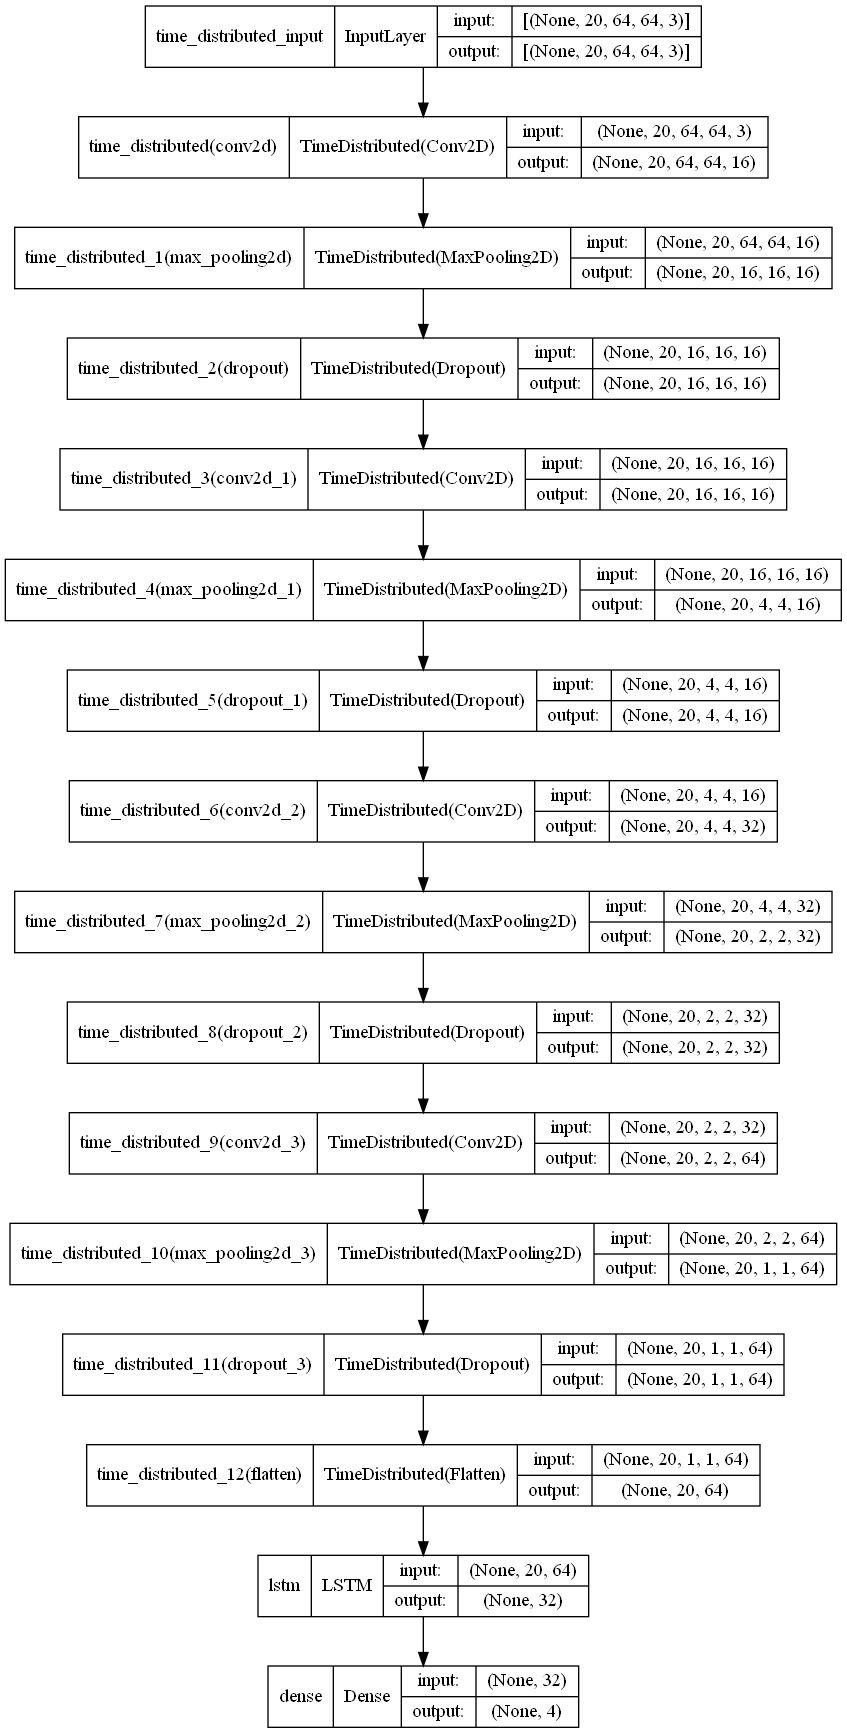

In [14]:
plot_model(model=lrcn_model,to_file='LRCN_model.png',show_shapes=True,show_layer_names=True)

In [17]:
optimizer=Adam(learning_rate=0.0001)
lrcn_model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 40, mode = 'min', restore_best_weights = True)
 

In [ ]:
lrcn_model_history=lrcn_model.fit(x=features_train,y=labels_train,epochs=300,
                                 batch_size=12,verbose=True,validation_split=0.2,
                                 shuffle=True,callbacks=[early_stopping_callback])

Epoch 1/300
24/24 [==============================] - 2s 31ms/step - loss: 1.1362 - accuracy: 0.5315 - val_loss: 1.3076 - val_accuracy: 0.3750
Epoch 2/300
24/24 [==============================] - 0s 14ms/step - loss: 1.1216 - accuracy: 0.5280 - val_loss: 1.4107 - val_accuracy: 0.3194
Epoch 3/300
24/24 [==============================] - 0s 15ms/step - loss: 1.1038 - accuracy: 0.5035 - val_loss: 1.4384 - val_accuracy: 0.2917
Epoch 4/300
24/24 [==============================] - 0s 15ms/step - loss: 1.1290 - accuracy: 0.5070 - val_loss: 1.3936 - val_accuracy: 0.3333
Epoch 5/300
24/24 [==============================] - 0s 15ms/step - loss: 1.1191 - accuracy: 0.5175 - val_loss: 1.5107 - val_accuracy: 0.2917
Epoch 6/300
24/24 [==============================] - 0s 15ms/step - loss: 1.1209 - accuracy: 0.5315 - val_loss: 1.3335 - val_accuracy: 0.3750
Epoch 7/300
24/24 [==============================] - 0s 14ms/step - loss: 1.0978 - accuracy: 0.5350 - val_loss: 1.3360 - val_accuracy: 0.3750
Epoch 

In [76]:
lrcn_model.evaluate(features_test,labels_test,verbose=1)


4/4 [==============================] - 1s 52ms/step - loss: 0.9207 - accuracy: 0.8417


[0.9206984043121338, 0.8416666388511658]

Text(0.5, 1.0, 'loss vs val_loss')

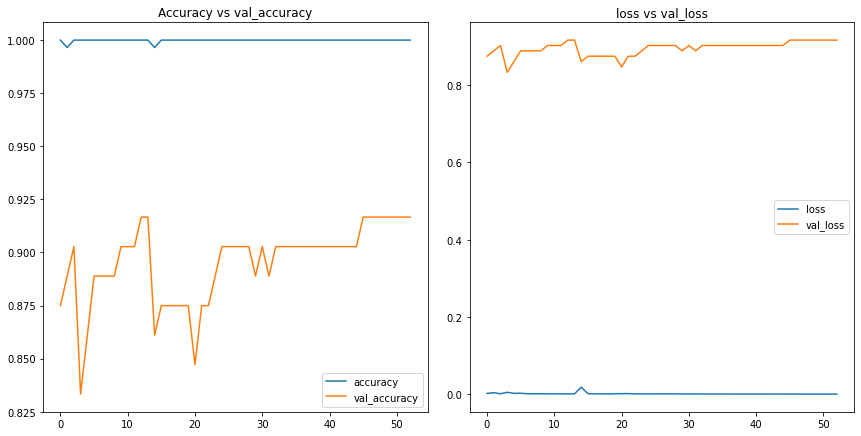

In [77]:
fig,axes=plt.subplots(1,2,figsize=(12,6))
fig.tight_layout()
axes[0].plot(lrcn_model_history.history['accuracy'],label='accuracy')
axes[0].plot(lrcn_model_history.history['val_accuracy'],label='val_accuracy')
axes[1].plot(lrcn_model_history.history['loss'],label='loss')
axes[1].plot(lrcn_model_history.history['val_accuracy'],label='val_loss')
axes[0].legend()
axes[1].legend()
axes[0].set_title("Accuracy vs val_accuracy")
axes[1].set_title('loss vs val_loss')

In [ ]:
## Testing on Video

In [78]:
lrcn_model.save('LRCN_saved_model')

INFO:tensorflow:Assets written to: LRCN_saved_model\assets


INFO:tensorflow:Assets written to: LRCN_saved_model\assets


In [7]:
lrcn_model=load_model('LRCN_saved_model')

In [8]:
def download_youtube_videos(youtube_video_url, output_directory):
     '''
    This function downloads the youtube video whose URL is passed to it as an argument.
    Args:
        youtube_video_url: URL of the video that is required to be downloaded.
        output_directory:  The directory path to which the video needs to be stored after downloading.
    Returns:
        title: The title of the downloaded youtube video.
    '''
 
     # Create a video object which contains useful information about the video.
     video = pafy.new(youtube_video_url)
 
     # Retrieve the title of the video.
     title = video.title
 
     # Get the best available quality object for the video.
     video_best = video.getbest()
 
     # Construct the output file path.
     output_file_path = f'{output_directory}/{title}.mp4'
 
     # Download the youtube video at the best available quality and store it to the contructed path.
     video_best.download(filepath = output_file_path, quiet = True)
 
     # Return the video title.
     return title

In [9]:
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)

# Download a YouTube Video.
video_title = download_youtube_videos('https://www.youtube.com/watch?v=8u0qjmHIOcE', test_videos_directory)

# Get the YouTube Video's path we just downloaded.
input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'

In [12]:

def predict_on_video(video_path,output_file_path,seq_len):
    
    
    video_reader=cv.VideoCapture(video_path)
    vides_total_frame=int(video_reader.get(cv.CAP_PROP_FRAME_COUNT))
    origianal_width=int(video_reader.get(cv.CAP_PROP_FRAME_WIDTH))
    original_height=int(video_reader.get(cv.CAP_PROP_FRAME_HEIGHT))
    video_writer = cv.VideoWriter(output_file_path, cv.VideoWriter_fourcc('M', 'P', '4', 'V'), 
                                   video_reader.get(cv.CAP_PROP_FPS), (origianal_width, original_height))
    
    
    frames_queue=deque(maxlen=seq_len)
    
    predicted_class_name=''
    start_time=time.time()
    
    while video_reader.isOpened():
        sucess,frame=video_reader.read()
        if not sucess:
            break
           
        resize_frame=cv.resize(frame,(resized_width,resized_height))
        normalised_frame=resize_frame/255.0
        frames_queue.append(normalised_frame)
       
           
        
            
        if len(frames_queue)==seq_len:
            
            predicted_label = np.argmax(lrcn_model.predict(np.expand_dims(frames_queue, axis = 0)))
            
            predicted_class=CLASSES_LIST[predicted_label]
            
            
            
            text='Class: {}'.format(predicted_class)
            
            
            
            cv.putText(frame, predicted_class, (10, 30), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)
            
           
        
        #cv.imshow('LRCN',frame)
        #if cv.waitKey(1) & 0xFF==ord('q'):
            #break
        video_writer.write(frame)
        
    end_time=time.time()
    
    print('start_time: {}'.format(start_time))
    print('end_time: {}'.format(end_time))
    print("num_frame: {}".format(vides_total_frame))
    seconds=end_time-start_time
    fps=vides_total_frame/seconds
    print(fps)
    video_writer.release()
    video_reader.release()
    #cv.destroyAllWindows()        
    
    

In [13]:
output_video_file_path = f'{test_videos_directory}/{video_title}-Output-SeqLen-1{seq_len}.mp4'
predict_on_video(input_video_file_path, output_video_file_path, seq_len)
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()



start_time: 1644611319.9106736
end_time: 1644611348.4308572
num_frame: 866
30.36446094675308
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [15]:
test_videos_directory = 'test_videos'
seq_len=20
video_reader=cv.VideoCapture(input_video_file_path)
#origianal_width=int(video_reader.get(cv.CAP_PROP_FRAME_WIDTH))
#original_height=int(video_reader.get(cv.CAP_PROP_FRAME_HEIGHT))
#video_writer = cv.VideoWriter(output_file_path, cv.VideoWriter_fourcc('M', 'P', '4', 'V'), 
                               #video_reader.get(cv.CAP_PROP_FPS), (origianal_width, original_height))

frames_queue=deque(maxlen=seq_len)

predicted_class_name=''
t1=0

while video_reader.isOpened():
    sucess,frame=video_reader.read()
    if not sucess:
        break
    resize_frame=cv.resize(frame,(resized_width,resized_height))
    normalised_frame=resize_frame/255.0
    frames_queue.append(normalised_frame)
    if len(frames_queue)==1:
        t1=time.time()
    if len(frames_queue)==seq_len:
        predicted_label = np.argmax(lrcn_model.predict(np.expand_dims(frames_queue, axis = 0)))

        predicted_class=CLASSES_LIST[predicted_label]
        fps=20/(time.time()-t1)
        text='Class: {}'.format(predicted_class)
        fps=int(fps)
        fps_text='fps: {}'.format(fps)
        cv.putText(frame, predicted_class, (10, 30), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)
        cv.putText(frame, fps, (60, 30), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)
        t1=0

    cv.imshow('LRCN',frame)
    if cv.waitKey(1) & 0xFF==ord('q'):
        break
    #video_writer.write(frame)


#video_writer.release()
video_reader.release()
cv.destroyAllWindows()

error: OpenCV(4.5.4) :-1: error: (-5:Bad argument) in function 'putText'
> Overload resolution failed:
>  - Can't convert object of type 'int' to 'str' for 'text'
>  - Can't convert object of type 'int' to 'str' for 'text'


In [56]:
866/30

28.866666666666667

In [ ]:
predicted=lrcn_model.predict(test_1)

In [ ]:
predicted=np.argmax(predicted)

In [ ]:
np.argmax(predicted)